In [1]:
import numpy as np
import math
import jax
import jax.numpy as jnp
import jax.lax as lax
import optax  
import equinox as eqx

## Toy Data Set Ups

In [4]:
#Toy Data: Bimodal data in the paper
class Bimodal():
  def __init__(self):
    self.sig = 0.05

  def TrueFunc(self, X):
    p = 1/(1+np.exp(-1.5*X))
    Y=np.zeros((len(X),1))
    for i, a in enumerate(p):
        Y[i,0] = np.random.binomial(1,a,1)
    Z = 0.2*X + Y + np.random.randn(len(Y),1)*(X*0.05)

    return Z

  def generate_train(self, N_x, N_y=1):
    X = np.random.uniform(-5, 5, (N_x,1))
    y = self.TrueFunc(X)

    return [X,y]

  def generate_test(self, N_y, N_x=200):
    Xp = np.array([np.linspace(-5,5,N_x)]).T
    Xp=np.repeat(Xp, N_y, axis=0)
    yp = self.TrueFunc(Xp)
    yp=np.reshape(yp, [N_x, N_y, 1])
    Xp=np.reshape(Xp, [N_x, N_y, 1])

    return [Xp,yp]

/var/folders/9v/bvw82hr17d5cyt29_v7bwb8r0000gn/T/ipykernel_6855/2985575698.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y[i,0] = np.random.binomial(1,a,1)


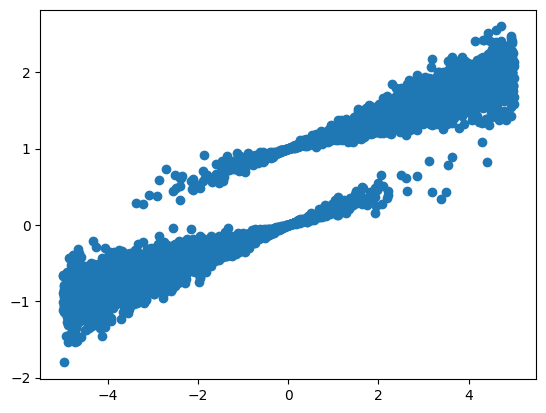

In [40]:
import matplotlib.pyplot as plt
#training data
X, y=Bimodal().generate_train(5000)
plt.scatter(X,y)

#test data
Xp, yp=Bimodal().generate_test(50)
Xpp=Xp[:,0,:]
ypp=yp[:,0,:]

## Defining NN-Based CME 

In [12]:
#Gaussian Density Kernel
def Gram(X, Y, sig):
  def pairwisedist(X,Y):
    def dist(x,y):
      z=x-y
      return jnp.sqrt(jnp.sum(jnp.square(z)))
    vmapped_dist = jax.vmap(dist, in_axes=(0, None))
    return jax.vmap(vmapped_dist, in_axes=(None, 0))(X,Y)
  S = pairwisedist(X, Y).T
  scale=jnp.sqrt(2*math.pi*(sig**2))
  return jnp.exp(- (S**2) / (2*sig**2))/scale


#Two-Layer NN
class NN(eqx.Module):
  layers: list
  ypcl: jax.Array
  sig: jax.Array
  def __init__(self, num_inputs, num_outputs, ypcl, sig_init, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        self.layers = [
            eqx.nn.Linear(num_inputs, 50, key=key1),
            eqx.nn.Linear(50, 50, key=key2),
            eqx.nn.Linear(50, num_outputs, key=key3),
        ]
        self.ypcl = ypcl
        self.sig = jnp.log(jnp.expm1(sig_init))

  def __call__(self, x, state):
      x = jax.nn.relu(self.layers[0](x))
      x = jax.nn.relu(self.layers[1](x))
      x = self.layers[2](x)
      sig = jax.nn.softplus(self.sig)

      return x, state, lax.stop_gradient(self.ypcl), sig

## Training (Proposal-Joint)

In [13]:
def sample_batch(X, Y, batch_size, key):
  indexes = jax.random.randint(key, shape=(batch_size, ), minval=0, maxval=X.shape[0])
  return X[indexes], Y[indexes]

def compute_loss(model, state, X, Y):
  batch_model = jax.vmap(model, in_axes=(0, None), out_axes=(0, None, None, None))
  f, state, ypcl, sig = batch_model(X, state)
  loss= -2 * (Gram(Y, ypcl, sig)@f.T).diagonal().sum()+(Gram(ypcl, ypcl, sig)*(f.T@f)).sum()
  return loss/X.shape[0], state

@eqx.filter_jit
def make_step(model, state, optim, opt_state, X, Y, batch_size, key):
  x, y = sample_batch(X, Y, batch_size, key)
  grads, state = eqx.filter_grad(compute_loss, has_aux=True)(model, state, x, y)
  updates, opt_state = optim.update(grads, opt_state, model)
  model = eqx.apply_updates(model, updates)
  return model, state, opt_state

def train(model, state, optim, opt_state, X, Y, batch_size, num_steps, key):
  for steps in range(num_steps):
    key, sub_key = jax.random.split(key, 2)
    model, state, opt_state = make_step(model, state, optim, opt_state, X, Y, batch_size, sub_key)
  return model, state

In [41]:
#random seeds
seed = 5678
key = jax.random.PRNGKey(seed)
mkey, xkey, xkey2 = jax.random.split(key, 3)

num_inputs = X.shape[1]

#location points
numAtom = 100
ymin = np.min(y)
ymax= np.max(y)
ypcl = jnp.array([np.linspace(ymin,ymax,numAtom)]).T

#initial bandwidth
sig_init = jnp.array(1.0)

#initialize NN
model, state = eqx.nn.make_with_state(NN)(num_inputs, numAtom, ypcl, sig_init, mkey)

#optimizer
optim = optax.adamw(1e-4)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

#batch size/epochs
batch_size = 50
num_steps = int(5000/batch_size)*1000

#train model
model, state = train(model, state, optim, opt_state, X, y, batch_size, num_steps, xkey)

## Kernel Herding (Sampling) on Test Points

In [16]:
def eval_NKME(model, state, Gram, Xpp, yc):
  inference_model = eqx.nn.inference_mode(model)
  batch_inference_model = jax.vmap(inference_model, in_axes=(0, None), out_axes=(0, None, None, None))
  f, state, ypcl, sig = batch_inference_model(Xpp, state)
  f=f/(f.sum(1, keepdims = True))
  kernelmean=(Gram(yc, ypcl, sig)@f.T).T
  return kernelmean,sig

def NKME_herding(mean_embedding, Gram, N_y, yc, sig):
  super_samples = jnp.zeros((mean_embedding.shape[0], N_y, yc.shape[1]))
  @jax.jit
  def herding_objective(super_samples, yc, mu, mu_hat_sum, sig, i):
    mu_hat = mu_hat_sum / (i + 1)
    objective = mu - mu_hat
    super_samples = super_samples.at[:,i,:].set(yc[jnp.argmax(objective, axis=1)])
    mu_hat_sum_updated = mu_hat_sum + Gram(super_samples[:,i,:], yc, sig)
    return super_samples, mu_hat_sum_updated

  mu = mean_embedding
  mu_hat_sum = jnp.zeros((mu.shape[0], mu.shape[1]))
  for i in range(N_y):
    super_samples, mu_hat_sum = herding_objective(super_samples, yc, mu, mu_hat_sum, sig, i)
  return super_samples

In [44]:
yc = np.array([np.linspace(ymin,ymax,1000)]).T

#Evaluate KME for test points
kernelmean, sig = eval_NKME(model, state, Gram, Xpp, yc)

#Kernel Herding
points = NKME_herding(kernelmean, Gram, 50, yc, sig)

## Evaluate Wasserstein Distance

In [32]:
import scipy
def wasserstein(true_points, sample_points):
  WAS=np.zeros((true_points.shape[0], 1))
  if true_points.shape[2]==1:
    for i in range(len(true_points)):
      WAS[i]=scipy.stats.wasserstein_distance(true_points[i][:,0], sample_points[i][:,0])
  else:
    for i in range(len(true_points)):
      d=cdist(true_points[i], sample_points[i])
      assignment= scipy.optimize.linear_sum_assignment(d)
      WAS[i]=d[assignment].sum()/true_points.shape[1]
  return WAS

In [43]:
# Calculate WAS-1
was = wasserstein(yp, points).mean()
print(was)

0.052600705383975266
